## Initialization

In [1]:
#!pip install -U tensorflow

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import os
import shutil
from os import path
from PIL import Image
import time

In [4]:
import tensorflow as tf
from tensorflow import keras

2024-08-11 10:33:04.839706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 10:33:04.839830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 10:33:04.973531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
train_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
test_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'
validation_add = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'

In [6]:
test_def = pd.DataFrame(os.listdir(train_add + '/Defective'))
test_ndef = pd.DataFrame(os.listdir(train_add + '/Non defective'))
val_def = pd.DataFrame(os.listdir(test_add + '/Defective'))
val_ndef = pd.DataFrame(os.listdir(test_add + '/Non defective'))
train_def = pd.DataFrame(os.listdir(validation_add + '/Defective'))
train_ndef = pd.DataFrame(os.listdir(validation_add + '/Non defective'))

In [7]:
print("Size of training dataset: ", len(train_def)+len(train_ndef))
print("Size of test dataset: ", len(test_def)+len(test_ndef))
print("Size of validation dataset: ", len(val_def)+len(val_ndef))

Size of training dataset:  62
Size of test dataset:  300
Size of validation dataset:  22


In [8]:
print("Train Defective count:", len(train_def))
print("Train Non defective count", len(train_ndef))
print("Test Defective count:", len(test_def))
print("Test Non defective count", len(test_ndef))
print("Validation Defective count:", len(val_def))
print("Validation Non defective count", len(val_ndef))

Train Defective count: 31
Train Non defective count 31
Test Defective count: 150
Test Non defective count 150
Validation Defective count: 11
Validation Non defective count 11


## Creating train, test and validation sets

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 62 files belonging to 2 classes.
Found 22 files belonging to 2 classes.
Found 299 files belonging to 2 classes.


In [10]:
# Getting the class names in order
class_names = train_ds.class_names
print(class_names)

['Defective', 'Non defective']


In [11]:
# Normalize function
def normalize(image, label):
  image = tf.cast(image/256, tf.float32)
  return image, label

In [12]:
# Normalizing the train, test and validation data
train_ds = train_ds.map(normalize)
validation_ds = validation_ds.map(normalize)
test_ds = test_ds.map(normalize)

## Model Building

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [14]:
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Load ResNet50 without the top fully connected layers, with pre-trained ImageNet weights
conv_base = ResNet50(input_shape=input_shape,
                     include_top=False,
                     weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
# Setting some layers to be trainable for Fine-tuning
for layer in conv_base.layers[:165]:
   layer.trainable = False
for layer in conv_base.layers[165:]:
   layer.trainable = True

In [16]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_layer_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv

In [17]:
# Pass the inputs through the convolutional base
x = conv_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(2, activation='softmax')(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

In [18]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=1e-5, weight_decay=5e-4, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,234 (90.48 MB)

 Trainable params: 4,597,058 (17.54 MB)

 Non-trainable params: 19,122,176 (72.95 MB)

## Transfer Learning and Fine Tuning

In [19]:
present_epoch=0
history = model.fit(train_ds, validation_data=validation_ds, epochs=15)
present_epoch+=15

Epoch 1/15
1/2 ━━━━━━━━━━━━━━━━━━━━ 20s 21s/step - accuracy: 0.2812 - loss: 1.5605

I0000 00:00:1723372425.336584     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 16s/step - accuracy: 0.3411 - loss: 1.4285 - val_accuracy: 0.5000 - val_loss: 0.7916
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4157 - loss: 1.4086 - val_accuracy: 0.5000 - val_loss: 0.7927
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4580 - loss: 1.0966 - val_accuracy: 0.5000 - val_loss: 0.7939
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5427 - loss: 0.8797 - val_accuracy: 0.5000 - val_loss: 0.7945
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7016 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.7938
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6912 - loss: 0.5809 - val_accuracy: 0.5000 - val_loss: 0.7923
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6818 - loss: 0.5802 - val_accuracy: 0.5000 - val_loss: 0.7899
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.6596 - loss: 0.6017 - val_accuracy: 0.5000 - val_loss: 0.7873
Epoch 9/15
2/2 ━━━━━━━━━

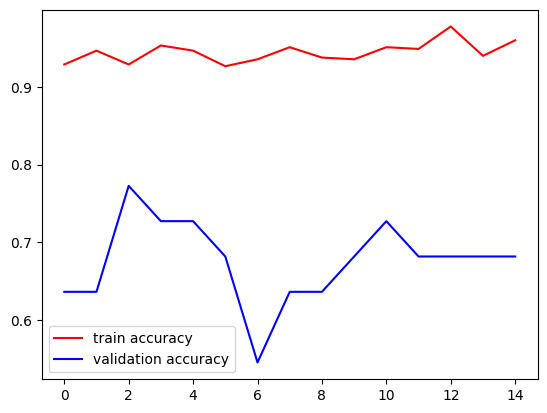

In [50]:
plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

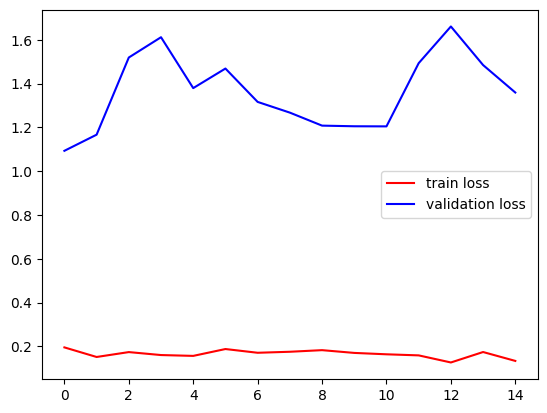

In [51]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

## Progressive Learning

In [22]:
# directory to store training data, this dataset keeps on updating throughout the training
if path.exists('semi_supervised') == False:
  os.mkdir('semi_supervised')

In [23]:
# Copying the actual training data in the semi_supervised dataset
!cp -r '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Defective' 'semi_supervised'
!cp -r '/kaggle/input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation/Non defective' 'semi_supervised'

In [24]:
# Variables to store count of defective and non-defective images
cntD=31 
cntNd=31

In [25]:
# Function to create Semi_supervised dataset
def create_ds_semi():
    ds = keras.utils.image_dataset_from_directory(
        directory = 'semi_supervised',
        labels='inferred',
        label_mode = 'int',
        batch_size=32,
        image_size=(256,256)
    )
    ds = ds.map(normalize)
    return ds

In [26]:
# Augmented dataset generated using Image Augmentation on the training data
augmented_dataset = '/kaggle/input/railway-track-augmented-dataset'

In [27]:
aug_df = pd.DataFrame(os.listdir(augmented_dataset))

**Testing**

In [28]:
import cv2

In [29]:
folder = augmented_dataset
for idx,image_path in enumerate(aug_df[0]):
  if(idx>2):
    break
  img = os.path.join(folder, image_path)
  print(img)
  test_img = cv2.imread(img)
  test_img = cv2.resize(test_img, (256,256))
  test_input = test_img.reshape((1,256,256,3))
  output = model.predict(test_input)

/kaggle/input/railway-track-augmented-dataset/aug_0_3310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
/kaggle/input/railway-track-augmented-dataset/aug_0_6810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
/kaggle/input/railway-track-augmented-dataset/aug_0_9711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [30]:
imgpath = '/kaggle/input/railway-track-augmented-dataset/aug_0_1125.jpg'

img = tf.keras.preprocessing.image.load_img(imgpath, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch axis

prediction = model.predict(img_array)
print(f"Prediction: {prediction}")

class_names =  ['Defective', 'Non defective']
predicted_class_index = np.argmax(prediction, axis=1)[0]
predicted_class = class_names[predicted_class_index]
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: [[0.64567506 0.35432497]]
Predicted class: Defective


In [31]:
# Creating a writable temporary directory
writable_temp_dir = '/kaggle/working/temp_augmented_dataset'

if not os.path.exists(writable_temp_dir):
    os.makedirs(writable_temp_dir)

# Copy files from read-only directory to writable temporary directory
for file_name in os.listdir(augmented_dataset):
    src_path = os.path.join(augmented_dataset, file_name)
    dest_path = os.path.join(writable_temp_dir, file_name)
    shutil.copy(src_path, dest_path)

In [32]:
augmented_dataset = '/kaggle/working/temp_augmented_dataset'

In [33]:
folder = augmented_dataset
aug_df = pd.DataFrame(os.listdir(augmented_dataset))
n = len(aug_df)
x= int(500*0.08) # To get upper limit for number of images to move from augmented_dataset to semi_supervised in each iteration
i=int(1) # Variable to keep track of number of iteration

In [34]:
def normalize_image(image):
    image = image / 255.0 
    return image

In [35]:
aug_df = pd.DataFrame(os.listdir(writable_temp_dir))

aug_ds =keras.utils.image_dataset_from_directory(
        directory = augmented_dataset,
        labels=None,  # No labels since we are predicting
        label_mode=None,  # No labels
        image_size=(256,256),
        batch_size=32,
        shuffle=False  # Keep the order of images
     )
file_paths = aug_ds.file_paths
aug_ds = aug_ds.map(lambda x: (normalize_image(x),))

Found 489 files.


**First Test Run**

In [36]:
# Dataframe to store information of predictions
temporary = pd.DataFrame(columns=['imagePath', 'confidence', 'tag'])

In [37]:
predictions = model.predict(aug_ds)

predicted_class_indices = np.argmax(predictions, axis=1)

# Map predicted indices to class names
confidence = [predictions[i][index] for i, index in enumerate(predicted_class_indices)]
predicted_class_names = [class_names[index] for index in predicted_class_indices]

# Checking for highly confident images
for file_path, prediction, predicted_class in zip(file_paths, confidence, predicted_class_names):
    if(prediction>0.85):
        temporary.loc[len(temporary.index)] = [file_path, prediction, predicted_class]

# Sorting the images on the basis of confidence scores
temporary = temporary.sort_values(by=['confidence'], ascending=False)
ct = int(x*i)
i+=1
for idx in temporary.index:
  if(temporary['tag'][idx]=='Defective'):
    cntD+=1
  else:
    cntNd+=1
  
  # Moving the highly confident images to semi_supervised directory with their respective pseudo-labels
  path_to_move = os.path.join('semi_supervised', temporary['tag'][idx])
  image_path = os.path.join(temporary['imagePath'][idx])
  shutil.move(image_path, os.path.join(path_to_move, os.path.basename(image_path)))


  if(idx>=ct):
        break

semi_train_ds = create_ds_semi()

print("Start training")
history = model.fit(semi_train_ds, validation_data=validation_ds, epochs=present_epoch+10, initial_epoch=present_epoch)
print("End Training")
present_epoch+=10


16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 710ms/step
Found 62 files belonging to 2 classes.
Start training
Epoch 16/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7547 - loss: 0.4371 - val_accuracy: 0.5000 - val_loss: 0.7609
Epoch 17/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8192 - loss: 0.3912 - val_accuracy: 0.5000 - val_loss: 0.7571
Epoch 18/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8303 - loss: 0.3230 - val_accuracy: 0.5000 - val_loss: 0.7532
Epoch 19/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7554 - loss: 0.4656 - val_accuracy: 0.5000 - val_loss: 0.7497
Epoch 20/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8616 - loss: 0.3314 - val_accuracy: 0.5000 - val_loss: 0.7458
Epoch 21/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7769 - loss: 0.3818 - val_accuracy: 0.5000 - val_loss: 0.7419
Epoch 22/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8935 - loss: 0.2701 - val_accuracy: 0.5000 - val_loss: 0.7385
Epoch 23/25
2/2 ━━━━━━━━━━━━━━━━━━━━

In [38]:
aug_df = pd.DataFrame(os.listdir(augmented_dataset))
n = len(aug_df)
semi_def = pd.DataFrame(os.listdir( 'semi_supervised/Defective'))
semi_ndef = pd.DataFrame(os.listdir( 'semi_supervised/Non defective'))
print("Size of training dataset: ", len(semi_def)+len(semi_ndef))
print("Size of augmented dataset: ", n)

Size of training dataset:  62
Size of augmented dataset:  489


In [39]:
ct

40

**Progressive Training Start**

In [40]:
st = time.time()

while(n>0):
  
  if(i>18):
        break

  temporary = pd.DataFrame(columns=['imagePath', 'confidence', 'tag'])
    
  aug_df = pd.DataFrame(os.listdir(augmented_dataset))

  aug_ds =keras.utils.image_dataset_from_directory(
          directory = augmented_dataset,
          labels=None,  # No labels since we are predicting
          label_mode=None,  # No labels
          image_size=(256,256),
          batch_size=32,
          shuffle=False  # Keep the order of images
     )
  file_paths = aug_ds.file_paths
  aug_ds = aug_ds.map(lambda x: (normalize_image(x),))

  predictions = model.predict(aug_ds)

  predicted_class_indices = np.argmax(predictions, axis=1)

  # Map predicted indices to class names
  confidence = [predictions[i][index] for i, index in enumerate(predicted_class_indices)]
  predicted_class_names = [class_names[index] for index in predicted_class_indices]

  # Checking for highly confident images
  for file_path, prediction, predicted_class in zip(file_paths, confidence, predicted_class_names):
      if prediction>0.85:
          temporary.loc[len(temporary.index)] = [file_path, prediction, predicted_class]
  
  # Sorting the images on the basis of confidence scores
  temporary = temporary.sort_values(by=['confidence'], ascending=False)
  ct = int(x*i)
  i+=1
  for idx in temporary.index:
    if(temporary['tag'][idx]=='Defective'):
      cntD+=1
    else:
      cntNd+=1
    
    # Moving the highly confident images to semi_supervised directory with their respective pseudo-labels
    path_to_move = os.path.join('semi_supervised', temporary['tag'][idx])
    image_path = os.path.join(temporary['imagePath'][idx])
    shutil.move(image_path, os.path.join(path_to_move, os.path.basename(image_path)))

    if(idx>=ct):
      break

  semi_train_ds = create_ds_semi()
  num_epochs=15
  if(i<10):
        num_epochs = 10
  else:
        num_epochs = 15
  print("Start training")
  history = model.fit(semi_train_ds, validation_data=validation_ds, epochs=present_epoch+num_epochs, initial_epoch=present_epoch)
  print("End Training")
  present_epoch+=num_epochs


  aug_df = pd.DataFrame(os.listdir(augmented_dataset))
  n = len(aug_df)
  semi_def = pd.DataFrame(os.listdir( 'semi_supervised/Defective'))
  semi_ndef = pd.DataFrame(os.listdir( 'semi_supervised/Non defective'))
  print("Size of training dataset: ", len(semi_def)+len(semi_ndef))
  print("Size of augmented dataset: ", n)
  
  if(n<50):
        break

print("Progressive Training End ")
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time/60, 'minutes')

Found 489 files.
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 679ms/step
Found 62 files belonging to 2 classes.
Start training
Epoch 26/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.8300 - loss: 0.3398 - val_accuracy: 0.5000 - val_loss: 0.7258
Epoch 27/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7762 - loss: 0.4147 - val_accuracy: 0.5000 - val_loss: 0.7230
Epoch 28/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8407 - loss: 0.3179 - val_accuracy: 0.5000 - val_loss: 0.7203
Epoch 29/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8088 - loss: 0.3632 - val_accuracy: 0.5000 - val_loss: 0.7178
Epoch 30/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9251 - loss: 0.2349 - val_accuracy: 0.5000 - val_loss: 0.7159
Epoch 31/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9254 - loss: 0.2252 - val_accuracy: 0.5000 - val_loss: 0.7140
Epoch 32/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8192 - loss: 0.3161 - val_accuracy: 0.5000 - val_loss: 0.7122
Epoch 33/35
2/2 ━━━

In [52]:
print(present_epoch)

245


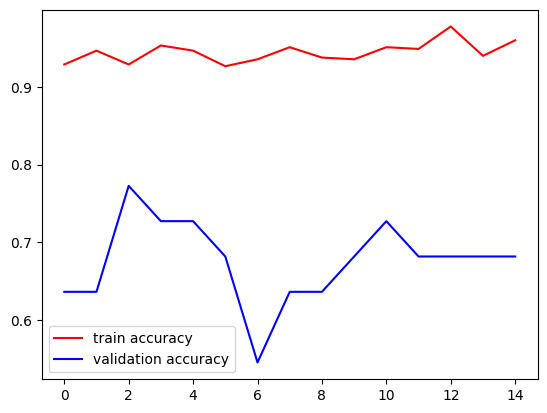

In [53]:
plt.plot(history.history['accuracy'],color='red',label='train accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='validation accuracy')
plt.legend()
plt.show()

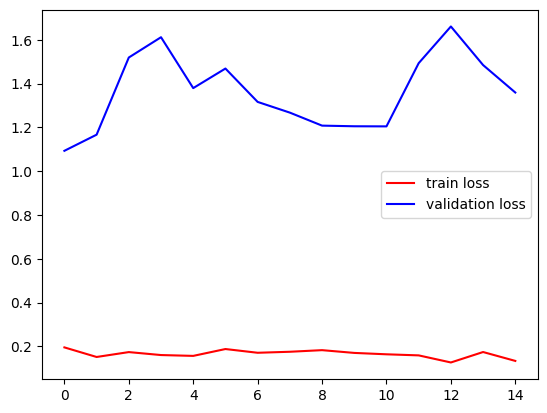

In [54]:
plt.plot(history.history['loss'],color='red',label='train loss')
plt.plot(history.history['val_loss'],color='blue',label='validation loss')
plt.legend()
plt.show()

In [55]:
semi_def = pd.DataFrame(os.listdir( 'semi_supervised' + '/Defective'))
semi_ndef = pd.DataFrame(os.listdir( 'semi_supervised' + '/Non defective'))
print("Size of training dataset: ", len(semi_def)+len(semi_ndef))

Size of training dataset:  450


## Evaluation

In [56]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5254 - loss: 2.0943


[2.3568079471588135, 0.5351170301437378]

In [57]:
model.evaluate(train_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0738


[0.07992938905954361, 1.0]

In [58]:
model.evaluate(validation_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6818 - loss: 1.3595


[1.3594813346862793, 0.6818181872367859]

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

In [61]:
# Get model predictions
predY = model.predict(test_ds)

y_pred = np.argmax(predY, axis=1)

# Collect the actual labels
y_actual = []
for images, labels in test_ds:
    y_actual.extend(labels.numpy())

y_actual = np.array(y_actual).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_actual, y_pred)
print("Confusion Matrix:\n", cm)

# Optionally, print classification report
print("Classification Report:\n", classification_report(y_actual, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Confusion Matrix:
 [[63 86]
 [65 85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.42      0.45       149
           1       0.50      0.57      0.53       150

    accuracy                           0.49       299
   macro avg       0.49      0.49      0.49       299
weighted avg       0.49      0.49      0.49       299

